In [1]:
import nilearn as nl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl
import time
import os
import math
from nilearn import plotting
from nilearn import datasets

### Data Generation

In [2]:
data = pkl.load(open( "../data/shuffled_data_pcp.p", "rb" ))
trn_x = data['trn_x']
trn_y = data['trn_y']
val_x = data['val_x']
val_y = data['val_y']

num_label = trn_y.shape[1]
num_trn = trn_x.shape[0]
num_val = val_x.shape[0]
num_node = 48

print(num_label, num_trn, num_val)

2 696 175


In [5]:
#Define the rewiring probabilities of two groups
num_channel = 1

#Computation graph params
num_conv_layer = 15
output_size = num_label
wd_rate = 0.0001
l_r = 0.001
num_epoch = 100
batch_size = 20

# 1st Convolutional Layer
filter_size = 3  # Convolution filters are 5 x 5 pixels.
num_filters = 16  # There are 16 of these filters.
stride = 1  # The stride of the sliding window

# Fully-connected layer.
h1 = 128  # Number of neurons in fully-connected layer.

In [6]:
#Prepare data
trn_x = trn_x.reshape(num_trn, num_node, num_node, num_channel)
val_x = val_x.reshape(num_val, num_node, num_node, num_channel)

[0. 1.]
[1. 0.]


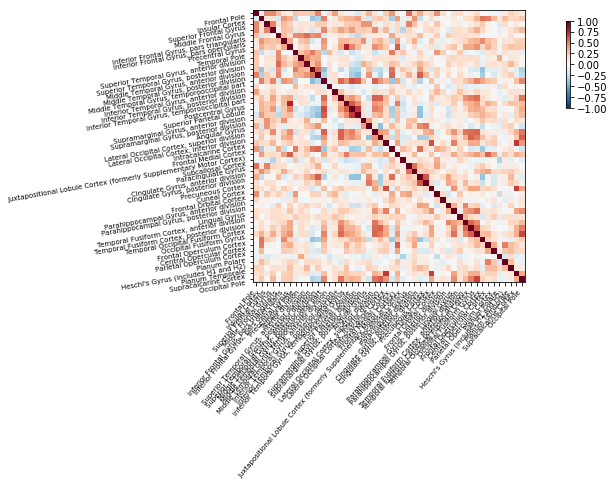

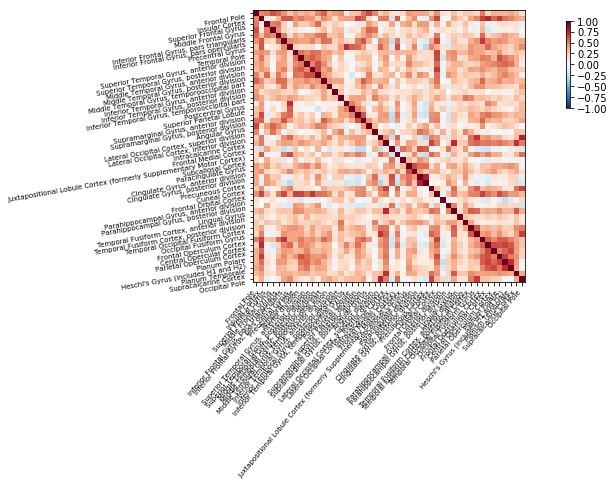

In [7]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

print(trn_y[20])
print(val_y[19])

display = plotting.plot_matrix(trn_x[20].reshape(48, 48), vmin=-1.0, vmax=1.0, colorbar=True, labels=labels[1:])
plotting.show()

display = plotting.plot_matrix(val_x[19].reshape(48, 48), vmin=-1.0, vmax=1.0, colorbar=True, labels=labels[1:])
plotting.show()

### Build Computation Graph

In [8]:
# weight and bais wrappers
def weight_variable(shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W',
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)

def bias_variable(shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b',
                           dtype=tf.float32,
                           initializer=initial)

def fc_layer(cur_layer, out_size):
    
    _, cur_size = [item.value for item in cur_layer.shape]
        
    var = 2.0 / (cur_size + out_size)

    stddev = math.sqrt(var)

    print("steddev is", stddev)
    print(out_size)

    with tf.name_scope('fc'):
        W_fc = tf.Variable(tf.truncated_normal(shape=[cur_size,out_size], stddev=stddev))
        b_fc = tf.Variable(tf.constant(0.0, shape=[out_size]))
        out_layer = tf.matmul(cur_layer, W_fc) + b_fc

    return out_layer

def conv_layer(x, filter_size, num_filters, stride, name):
    """
    Create a 2D convolution layer
    :param x: input from previous layer
    :param filter_size: size of each filter
    :param num_filters: number of filters (or output feature maps)
    :param stride: filter stride
    :param name: layer name
    :return: The output array
    """
    with tf.variable_scope(name):
        num_in_channel = x.get_shape().as_list()[-1]
        W = weight_variable(shape=[filter_size, filter_size, num_in_channel, num_filters])
        b = bias_variable(shape=[num_filters])
        layer = tf.nn.conv2d(x, W,
                             strides=[1, stride, stride, 1],
                             padding="SAME")
        layer += b
        return tf.nn.leaky_relu(layer)


def  max_pool(x, ksize, stride, name):
    """
    Create a max pooling layer
    :param x: input to max-pooling layer
    :param ksize: size of the max-pooling filter
    :param stride: stride of the max-pooling filter
    :param name: layer name
    :return: The output array
    """
    return tf.nn.max_pool(x,
                          ksize=[1, ksize, ksize, 1],
                          strides=[1, stride, stride, 1],
                          padding="SAME",
                          name=name)

def flatten_layer(layer):
    """
    Flattens the output of the convolutional layer to be fed into fully-connected layer
    :param layer: input array
    :return: flattened array
    """
    with tf.variable_scope('Flatten_layer'):
        layer_shape = layer.get_shape()
        num_features = layer_shape[1:4].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat

def activation(cur_layer, is_output=False):
    if is_output is True:
        return tf.nn.sigmoid(cur_layer)
    return tf.nn.leaky_relu(cur_layer)

def loss_function(yhat, y):
    '''
    '''
    # get the weight decay terms
    with tf.name_scope('wd_term'):
        wght_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='fc')
        wd_term = wd_rate * tf.stack([tf.nn.l2_loss(i) for i in wght_params])

    with tf.name_scope('crit_loss'):
        crit = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat)) + tf.reduce_sum(wd_term)

    return crit

def generate_dataset(x, y, shuffle=True):
    with tf.name_scope('dataset'):
        dataset = tf.data.Dataset.from_tensor_slices((x, y))
        if shuffle: 
            dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
        else:
            dataset = dataset.batch(batch_size)

    return dataset.make_initializable_iterator()

In [9]:
#Build the actual graph
tf.reset_default_graph()
x_place = tf.placeholder('float', [None, num_node, num_node, num_channel], name='input_x')
y_place = tf.placeholder('float', [None,  output_size], name='target_y')
lr_place = tf.placeholder('float', name='learning_rate')
#Graph
cur_layer = x_place
for i in range(num_conv_layer):
    print(i)
    cur_layer = conv_layer(cur_layer, filter_size, num_filters, stride, name=('conv_' + str(i)))
    cur_layer = max_pool(cur_layer, ksize=2, stride=2, name=('pool_' + str(i)))
layer_flat = flatten_layer(cur_layer)
fc1 = fc_layer(layer_flat, h1)
fc1 = activation(fc1, False)
output_logits = fc_layer(fc1, num_label)
yhat_op = activation(output_logits, True)

#Cross entropy loss
loss_op = loss_function(yhat_op, y_place)
tf.summary.scalar('Cross_Entropy_Loss', loss_op)

#adam
optimizer = tf.train.AdamOptimizer(lr_place)
train_op = optimizer.minimize(loss_op)

#Accuracy
correct_pred = tf.equal(tf.argmax(y_place, 1), tf.argmax(yhat_op, 1))  
acc_op = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
tf.summary.scalar('Accuracy', acc_op)

#Iterators
trn_it = generate_dataset(trn_x, trn_y, shuffle=True)
val_it = generate_dataset(val_x, val_y, shuffle=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
steddev is 0.11785113019775792
128
steddev is 0.12403473458920845
2


In [10]:
#Actual train loop
if 'session' in locals() and session is not None:
    print('Close interactive session', flush=True)
    session.close()


sess = tf.Session()

# get the summary ready
merged = tf.summary.merge_all()
trn_writer = tf.summary.FileWriter("./log", sess.graph)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

# tracing the loss along the way
meta_info = {}
meta_info['trn_loss'] = []
meta_info['trn_acc'] = []
meta_info['val_loss'] = []
meta_info['val_acc'] = []
meta_info['tst_loss'] = []
meta_info['tst_acc'] = []
iteration = 0
  
for ep in range(num_epoch):
    sess.run(trn_it.initializer)
    sess.run(val_it.initializer)

    trn_next_batch = trn_it.get_next()

    avg_trn_loss = 0
    avg_trn_acc = 0
    print('TRN:', flush=True)
    n_lr = l_r
    while True: # loop to iterate over training set
        try: 
            x, y = sess.run(trn_next_batch)
        except: 
            break
        print('+', end='', flush=True)
        iteration += 1
        
        this_batch_size = x.shape[0]

        _, loss_i, acc_i, summary_i, _yhat, _pred = sess.run([train_op, loss_op, acc_op, merged, yhat_op, correct_pred], 
                                                   feed_dict={x_place:x, y_place:y, lr_place:n_lr})

        trn_writer.add_summary(summary_i, iteration)
        avg_trn_loss = avg_trn_loss + loss_i*this_batch_size
        avg_trn_acc = avg_trn_acc + acc_i*this_batch_size
        
        '''print(_yhat, flush=True)
        print(y, flush=True)
        print(_pred, flush=True)
        print(acc_i, flush=True)'''
    
    avg_trn_loss = avg_trn_loss/num_trn
    avg_trn_acc = avg_trn_acc/num_trn
    
    #Validation
    avg_val_loss = 0
    avg_val_acc = 0
    print('VAL:', flush=True)
    # evaluate the loss and accuracy
    pred_and_gt = {}
    pred_and_gt['x'] = []
    pred_and_gt['y'] = []
    pred_and_gt['yhat'] = []
    
    val_next_batch = val_it.get_next()

    while True:
        try: x, y = sess.run(val_next_batch)
        except: break
        print('+', end='', flush=True)
        
        this_batch_size = x.shape[0]
        # compute the loss
        _yhat, _loss, _acc = sess.run([yhat_op, loss_op, acc_op], 
                                   feed_dict={x_place:x, y_place:y})

        # keep track of the loss/pred_and_gt
        pred_and_gt['x'].append(x)
        pred_and_gt['y'].append(y)
        pred_and_gt['yhat'].append(_yhat)
        avg_val_loss = avg_val_loss + _loss*this_batch_size
        avg_val_acc = avg_val_acc + _acc*this_batch_size
    
    avg_val_loss = avg_val_loss/num_val
    avg_val_acc = avg_val_acc/num_val

    print('', flush=True)

    # concatenate the list to numpy array
    for k, v in pred_and_gt.items():
        pred_and_gt[k] = np.concatenate(v)
    
    
    print('\nEp.%05d - TRN: loss %.2f VAL: loss %.2f' % (ep, avg_trn_loss, avg_val_loss), flush=True)
    print('\nEp.%05d - TRN: acc %.2f VAL: acc %.2f' % (ep, avg_trn_acc, avg_val_acc), flush=True)
        
        
    # save learning meta information
    meta_info['trn_loss'].append(avg_trn_loss)
    meta_info['trn_acc'].append(avg_trn_acc)
    meta_info['val_loss'].append(avg_val_loss)
    meta_info['val_acc'].append(avg_val_acc)
    
pkl.dump(meta_info, open(os.path.join('.', 'result.p'), 'wb'))
saver.save(sess, "./model/model")
sess.close()

TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00000 - TRN: loss 0.69 VAL: loss 0.69

Ep.00000 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00001 - TRN: loss 0.69 VAL: loss 0.69

Ep.00001 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00002 - TRN: loss 0.69 VAL: loss 0.69

Ep.00002 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00003 - TRN: loss 0.69 VAL: loss 0.69

Ep.00003 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00004 - TRN: loss 0.69 VAL: loss 0.69

Ep.00004 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00005 - TRN: loss 0.69 VAL: loss 0.69

Ep.00005 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00006 - TRN: loss 0.69 VAL: loss 0.69

Ep.00006 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++V

TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00060 - TRN: loss 0.69 VAL: loss 0.69

Ep.00060 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00061 - TRN: loss 0.69 VAL: loss 0.69

Ep.00061 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00062 - TRN: loss 0.69 VAL: loss 0.69

Ep.00062 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00063 - TRN: loss 0.69 VAL: loss 0.69

Ep.00063 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00064 - TRN: loss 0.69 VAL: loss 0.69

Ep.00064 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00065 - TRN: loss 0.69 VAL: loss 0.69

Ep.00065 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++VAL:
+++++++++

Ep.00066 - TRN: loss 0.69 VAL: loss 0.69

Ep.00066 - TRN: acc 0.54 VAL: acc 0.51
TRN:
+++++++++++++++++++++++++++++++++++V

In [ ]:
#Little test
test_x = val_x[47].reshape(1, num_node, num_node, num_channel)
#test_x[0, :] = val_x[45]


tf.reset_default_graph()

imported_graph = tf.train.import_meta_graph('./model/model.meta')

for tensor in tf.get_default_graph().get_operations():
    print (tensor.name)

with tf.Session() as sess:
    imported_graph.restore(sess, './model/model')
    yhat = sess.run(['Sigmoid:0'], feed_dict={'input_x:0':test_x})
    print(yhat)

print(val_y[47])